# DSA5101 Project

## Exploring different types of recommender systems on MovieLens100k Dataset

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
- 100,000 ratings (1-5) from 943 users on 1682 movies. 
- Each user has rated at least 20 movies. 
- Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set.

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

First, let's import the dataset and analyse it

In [219]:
overall_stats = pd.read_csv('./ml-100k/u.info', header=None)
print("Details of users, items and ratings: ",list(overall_stats[0]))

Details of users, items and ratings:  ['943 users', '1682 items', '100000 ratings']


In [220]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings = pd.read_csv('ml-100k/u.data', header=None, sep='\t', names=column_names1)
ratings.drop("timestamp", axis=1, inplace=True) 
# Drop timestamp column as it will not be used as part of the recommender system

print(ratings.shape)
ratings.head()

(100000, 3)


,user id,movie id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [221]:
column_names2 = "movie id | movie title | release date | video release date | \
IMDb URL | unknown | Action | Adventure | Animation | \
Children's | Comedy | Crime | Documentary | Drama | Fantasy | \
Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | \
Thriller | War | Western"

column_names2 = column_names2.split(" | ")

movies = pd.read_csv('ml-100k/u.item', sep='|', header=None, names=column_names2, encoding='latin-1')
print(movies.shape)
movies.head()

(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [222]:
column_names3 = "user id | age | gender | occupation | zip code"
column_names3 = column_names3.split(" | ")

users = pd.read_csv("ml-100k/u.user", header=None, sep='|', names=column_names3)
print(users.shape)
users.head()

(943, 5)


,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
# Data Processing for collaborative and content based filtering
genre_columns = movies.columns[5:]

merged_ratings_movies = ratings.merge(movies[['movie id', 'movie title'] + list(genre_columns)], on='movie id')
genre_features = movies.drop(columns=['release date', 'video release date', 'IMDb URL'])
merged_ratings_users = ratings.merge(users, on='user id')

In [224]:
print(merged_ratings_movies.shape)
merged_ratings_movies.head()

(100000, 23)


,user id,movie id,rating,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,Kolya (1996),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,L.A. Confidential (1997),0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,Heavyweights (1994),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,Jackie Brown (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
print(genre_features.shape)
genre_features.head()

(1682, 21)


,movie id,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [226]:
print(merged_ratings_users.shape)
merged_ratings_users.head()

(100000, 7)


,user id,movie id,rating,age,gender,occupation,zip code
0,196,242,3,49,M,writer,55105
1,186,302,3,39,F,executive,00000
2,22,377,1,25,M,writer,40206
3,244,51,2,28,M,technician,80525
4,166,346,1,47,M,educator,55113


## Data Visualisation

To better understand the distribution of our data, let's plot some charts to visualise trends

### Distribution of ratings

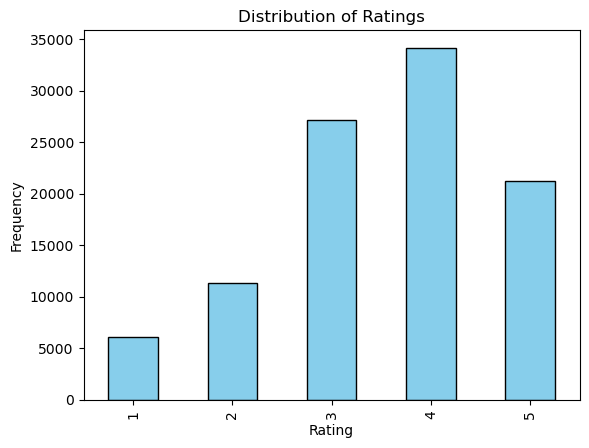

In [227]:
# Plot the distribution of ratings
ratings['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Histogram of Ratings per user

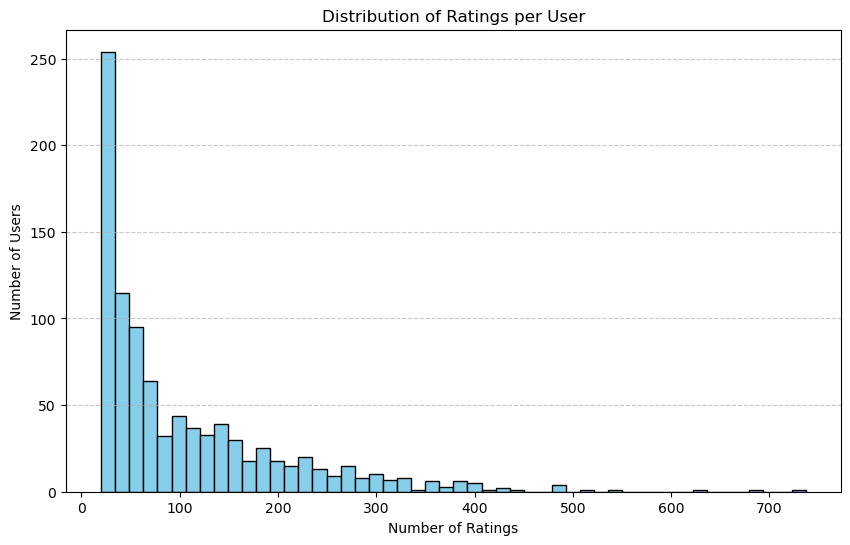

In [228]:
ratings_per_user = ratings.groupby('user id').size()

plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Histogram of Ratings per movie

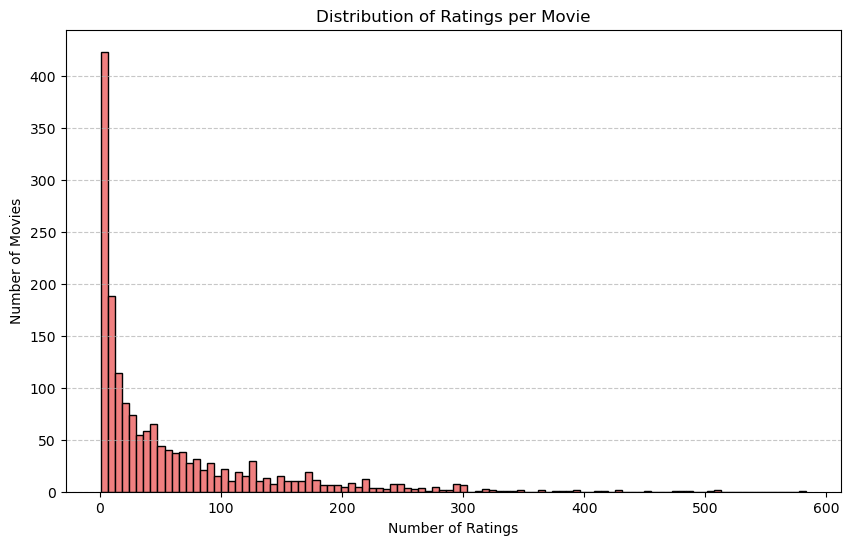

In [229]:
ratings_per_movie = ratings.groupby('movie id').size()

plt.figure(figsize=(10, 6))
plt.hist(ratings_per_movie, bins=100, color='lightcoral', edgecolor='black')
plt.title("Distribution of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Heatmap of user-item matrix density

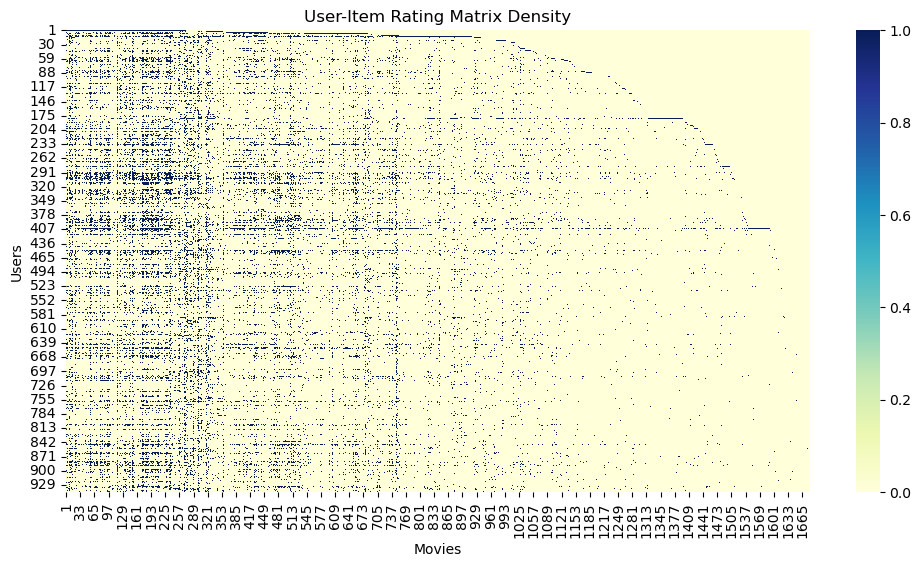

In [230]:
# Generate a binary matrix (1 for rated, 0 for not rated)
user_item_matrix = ratings.pivot(index='user id', columns='movie id', values='rating').notna()
user_item_matrix = user_item_matrix.astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(user_item_matrix, cmap="YlGnBu", cbar=True)
plt.title("User-Item Rating Matrix Density")
plt.xlabel("Movies")
plt.ylabel("Users")
plt.show()

### Average ratings per movie genre

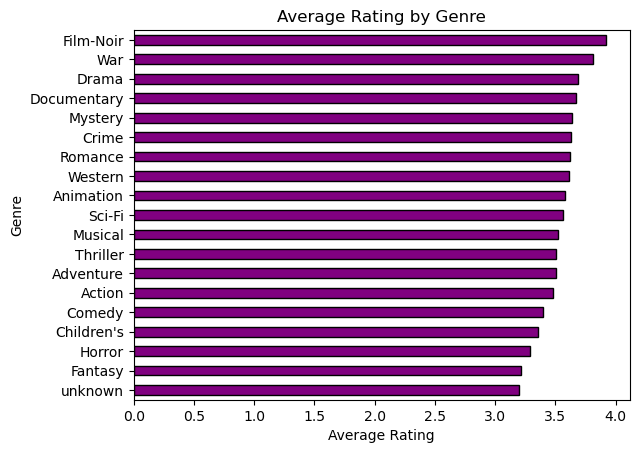

In [231]:
# Create a dictionary to store average ratings per genre
genre_columns = movies.columns[5:]  # Assuming genres start from column 5
genre_ratings = {genre: merged_ratings_movies[merged_ratings_movies[genre] == 1]['rating'].mean() for genre in genre_columns}

# Convert to Series and plot
pd.Series(genre_ratings).sort_values().plot(kind='barh', color='purple', edgecolor='black')
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

## KNN Collaborative Filtering

Default parameters:
- Minimum number of neighbours = 1
- Maximum number of neighbours = 40

In [232]:
# Surprise is a Python scikit for building and analyzing recommender systems
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split, GridSearchCV, KFold
from surprise.accuracy import rmse, mae

In [233]:
# Load dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

# trainset
testset

[(907, 143, 5.0),
 (371, 210, 4.0),
 (218, 42, 4.0),
 (829, 170, 4.0),
 (733, 277, 1.0),
 (363, 1512, 1.0),
 (193, 487, 5.0),
 (808, 313, 5.0),
 (557, 682, 2.0),
 (774, 196, 3.0),
 (638, 118, 3.0),
 (632, 81, 5.0),
 (417, 200, 4.0),
 (580, 471, 3.0),
 (640, 91, 4.0),
 (450, 328, 4.0),
 (596, 13, 2.0),
 (586, 467, 4.0),
 (653, 502, 2.0),
 (378, 517, 3.0),
 (405, 65, 1.0),
 (279, 399, 4.0),
 (327, 293, 3.0),
 (346, 276, 1.0),
 (59, 928, 4.0),
 (514, 22, 4.0),
 (807, 402, 5.0),
 (473, 327, 3.0),
 (342, 324, 1.0),
 (269, 136, 4.0),
 (654, 1, 4.0),
 (250, 28, 4.0),
 (282, 689, 2.0),
 (534, 619, 4.0),
 (194, 481, 3.0),
 (184, 118, 2.0),
 (291, 739, 3.0),
 (293, 31, 2.0),
 (943, 1028, 2.0),
 (65, 69, 3.0),
 (562, 135, 5.0),
 (466, 62, 3.0),
 (847, 317, 3.0),
 (650, 521, 3.0),
 (656, 326, 1.0),
 (366, 53, 5.0),
 (15, 280, 3.0),
 (474, 322, 4.0),
 (90, 905, 4.0),
 (503, 19, 5.0),
 (334, 1524, 4.0),
 (90, 632, 5.0),
 (406, 1118, 3.0),
 (899, 515, 3.0),
 (13, 339, 3.0),
 (430, 19, 5.0),
 (24, 729

### Grid Search Cross Validation for User-Based Cosine Similarity

In [234]:
# For user-based collaborative filtering
kf = KFold(random_state=0)
param_grid = {
    'k': [10, 20, 30, 40, 50, 60],
    'min_k': [1, 3, 5, 7, 10],
    'sim_options': {
        'name': ['cosine'],
    }
}
user_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=kf, n_jobs=-1)
user_knn.fit(data)

# Print best parameters for user-based filtering
print("Best parameters for user-based cosine filtering:")
print(user_knn.best_params['rmse'])
print(user_knn.best_params['mae'])

Best parameters for user-based cosine filtering:
{'k': 60, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}


### User-Based Cosine Similarity

In [ ]:
user_cosine_cf = KNNBasic(k=60, min_k=3, sim_options={'name': 'cosine', 'user_based': True})
user_cosine_cf.fit(trainset)
predictions_user_cosine_cf = user_cosine_cf.test(testset)

rmse_user_cosine_cf = rmse(predictions_user_cosine_cf)
mae_user_cosine_cf = mae(predictions_user_cosine_cf)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0191
MAE:  0.8047


### Grid Search Cross Validation for User-Based Pearson Similarity

In [236]:
# For user-based collaborative filtering
kf = KFold(random_state=0)
param_grid = {
    'k': [10, 20, 30, 40, 50, 60],
    'min_k': [1, 3, 5, 7, 10],
    'sim_options': {
        'name': ['pearson'],
    }
}
user_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=kf, n_jobs=-1)
user_knn.fit(data)

# Print best parameters for user-based filtering
print("Best parameters for user-based pearson filtering:")
print(user_knn.best_params['rmse'])
print(user_knn.best_params['mae'])

Best parameters for user-based pearson filtering:
{'k': 60, 'min_k': 3, 'sim_options': {'name': 'pearson', 'user_based': True}}
{'k': 60, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': True}}


### User-based Pearson Correlation Coefficient

In [ ]:
user_pearson_cf = KNNBasic(k=60, min_k=3, sim_options={'name': 'pearson', 'user_based': True})
user_pearson_cf.fit(trainset)
predictions_user_pearson_cf = user_pearson_cf.test(testset)

rmse_user_pearson_cf = rmse(predictions_user_pearson_cf)
mae_user_pearson_cf = mae(predictions_user_pearson_cf)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0131
MAE:  0.8031


### Grid Search Cross Validation for Item-based Cosine Similarity

In [238]:
# For item-based collaborative filtering
kf = KFold(random_state=0)
param_grid = {
    'k': [10, 20, 30, 40, 50, 60],
    'min_k': [1, 3, 5, 7, 10],
    'sim_options': {
        'name': ['cosine'],
        'user_based': [False]
    }
}
user_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=kf, n_jobs=-1)
user_knn.fit(data)

# Print best parameters for item-based filtering
print("Best parameters for item-based cosine filtering:")
print(user_knn.best_params['rmse'])
print(user_knn.best_params['mae'])

Best parameters for item-based cosine filtering:
{'k': 60, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': False}}
{'k': 60, 'min_k': 1, 'sim_options': {'name': 'cosine', 'user_based': False}}


### Item-Based Cosine Similarity

In [ ]:
sim_options = {
    "name": "cosine",
    "user_based": False,  # Compute similarities between items
}
item_cosine_cf = KNNBasic(k=60, min_k=1, sim_options=sim_options)
item_cosine_cf.fit(trainset)
predictions_item_cosine_cf = item_cosine_cf.test(testset)


rmse_item_cosine_cf = rmse(predictions_item_cosine_cf)
mae_item_cosine_cf = mae(predictions_item_cosine_cf)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0246
MAE:  0.8092


### Grid Search Cross Validation for Item-based Pearson Similarity

In [240]:
# For item-based collaborative filtering
kf = KFold(random_state=0)
param_grid = {
    'k': [10, 20, 30, 40, 50, 60],
    'min_k': [1, 3, 5, 7, 10],
    'sim_options': {
        'name': ['pearson'],
        'user_based': [False]
    }
}
user_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=kf, n_jobs=-1)
user_knn.fit(data)

# Print best parameters for item-based filtering
print("Best parameters for item-based pearson filtering:")
print(user_knn.best_params['rmse'])
print(user_knn.best_params['mae'])

Best parameters for item-based pearson filtering:
{'k': 60, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': False}}
{'k': 60, 'min_k': 1, 'sim_options': {'name': 'pearson', 'user_based': False}}


### Item-Based Pearson Correlation Coefficient

In [ ]:
sim_options = {
    "name": "pearson",
    "user_based": False,  # Compute similarities between items
}
item_pearson_cf = KNNBasic(k=60, min_k=1, sim_options=sim_options)
item_pearson_cf.fit(trainset)
predictions_item_pearson_cf = item_pearson_cf.test(testset)


rmse_item_pearson_cf = rmse(predictions_item_pearson_cf)
mae_item_pearson_cf = mae(predictions_item_pearson_cf)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0337
MAE:  0.8261


### Non-negative matrix factorization

In [242]:
from surprise import NMF
from surprise.model_selection import cross_validate

In [243]:
algo = NMF()
algo.fit(trainset)
predictions = algo.test(testset)
rmse_nmf = rmse(predictions)
mae_nmf = mae(predictions)

RMSE: 0.9699
MAE:  0.7632


### Perform cross validation with non-negative matrix factorization (NMF)

In [244]:
# Define a function to load the data
def load_data(file_path):
    data = pd.read_csv(f"ml-100k/{file_path}", sep='\t', header=None, names=['user', 'item', 'rating', 'timestamp'])
    return data

# Prepare a list of the file paths
train_files = ['u1.base', 'u2.base', 'u3.base', 'u4.base', 'u5.base']
test_files = ['u1.test', 'u2.test', 'u3.test', 'u4.test', 'u5.test']

# Initialize the reader for Surprise
reader = Reader(rating_scale=(1, 5))

# Initialize a dictionary to hold results
rmse_results = []
mae_results = []

# Iterate over each fold
for i in range(5):
    # Load the training and test data
    train_data = load_data(train_files[i])
    test_data = load_data(test_files[i])
    
    # Load into Surprise Dataset
    train_dataset = Dataset.load_from_df(train_data[['user', 'item', 'rating']], reader)
    test_dataset = Dataset.load_from_df(test_data[['user', 'item', 'rating']], reader)
    
    # Use the NMF algorithm for collaborative filtering
    algo = NMF()

    # Train the algorithm
    trainset = train_dataset.build_full_trainset()
    algo.fit(trainset)
    
    # Test the algorithm on the test data
    testset = test_dataset.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    
    # Calculate RMSE and MAE for this fold
    # rmse = sqrt(mean_squared_error([pred.r_ui for pred in predictions], [pred.est for pred in predictions]))
    root_mean_squared_error = rmse(predictions)
    mean_absolute_error = mae(predictions)
    rmse_results.append(root_mean_squared_error)
    mae_results.append(mean_absolute_error)
    print(f"Fold {i+1} RMSE: {root_mean_squared_error:.4f}")
    print(f"Fold {i+1} MAE: {mean_absolute_error:.4f}")

# Average RMSE and MAE across all folds
average_rmse = sum(rmse_results) / len(rmse_results)
average_mae = sum(mae_results) / len(mae_results)
print(f"\nAverage RMSE across all folds: {average_rmse:.4f}")
print(f"\nAverage MAE across all folds: {average_mae:.4f}")


RMSE: 0.9759
MAE:  0.7653
Fold 1 RMSE: 0.9759
Fold 1 MAE: 0.7653
RMSE: 0.9710
MAE:  0.7605
Fold 2 RMSE: 0.9710
Fold 2 MAE: 0.7605
RMSE: 0.9620
MAE:  0.7558
Fold 3 RMSE: 0.9620
Fold 3 MAE: 0.7558
RMSE: 0.9633
MAE:  0.7554
Fold 4 RMSE: 0.9633
Fold 4 MAE: 0.7554
RMSE: 0.9599
MAE:  0.7579
Fold 5 RMSE: 0.9599
Fold 5 MAE: 0.7579

Average RMSE across all folds: 0.9664

Average MAE across all folds: 0.7590


In [245]:
algo = NMF()
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
kf = KFold(random_state=0)  # folds will be the same for all algorithms. Default n_splits = 5

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=kf, verbose=True)


Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9682  0.9573  0.9558  0.9579  0.9755  0.9630  0.0076  
MAE (testset)     0.7610  0.7537  0.7502  0.7519  0.7672  0.7568  0.0064  
Fit time          2.93    2.73    3.10    2.30    2.04    2.62    0.40    
Test time         0.12    0.11    0.14    0.10    0.09    0.11    0.02    


{'test_rmse': array([0.96821064, 0.95731913, 0.95584229, 0.95793131, 0.97549558]),
 'test_mae': array([0.76104904, 0.75372299, 0.75017044, 0.75193081, 0.76716607]),
 'fit_time': (2.93393611907959,
  2.7339324951171875,
  3.0974695682525635,
  2.3011398315429688,
  2.0373759269714355),
 'test_time': (0.12165427207946777,
  0.10787343978881836,
  0.14205503463745117,
  0.09560871124267578,
  0.09457206726074219)}

## Content Based Filtering

We utilise the genre features of the movies, as well as the users' demographic data to create users and movies profiles

In [246]:
# One-hot encode categorical demographic data
users_encoded = pd.get_dummies(users, columns=['gender', 'occupation'], dtype=int)

users_encoded

,user id,age,zip code,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,1,24,85711,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,53,94043,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,3,23,32067,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,24,43537,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,33,15213,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,26,33319,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
939,940,32,02215,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
940,941,20,97229,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
941,942,48,78209,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [247]:
from sklearn.model_selection import train_test_split as sklearn_train_test_split

In [248]:
ratings_train, ratings_test = sklearn_train_test_split(ratings, test_size=0.2, random_state=42)

merged_ratings_movies_train = ratings_train.merge(movies[['movie id', 'movie title'] + list(genre_columns)], on='movie id', how='right')

merged_ratings_movies_train.fillna(0, inplace=True)

print(merged_ratings_movies_train.shape)
merged_ratings_movies_train


(80029, 23)


,user id,movie id,rating,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,99.0,1,4.0,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,23.0,1,5.0,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,141.0,1,3.0,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,691.0,1,5.0,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,838.0,1,5.0,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80024,863.0,1678,1.0,Mat' i syn (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80025,863.0,1679,3.0,B. Monkey (1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
80026,863.0,1680,2.0,Sliding Doors (1998),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
80027,896.0,1681,3.0,You So Crazy (1994),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [249]:
print(merged_ratings_movies.shape)
merged_ratings_movies.head()

(100000, 23)


,user id,movie id,rating,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,Kolya (1996),0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,L.A. Confidential (1997),0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,22,377,1,Heavyweights (1994),0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
4,166,346,1,Jackie Brown (1997),0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
movies.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [251]:
# Form movie profiles using user demographics and genre 
movie_demographics = merged_ratings_movies_train.merge(users_encoded, on='user id', how='left').drop(columns=['zip code'])

movie_demographics.fillna(0, inplace=True)

print(movie_demographics.shape)
movie_demographics

(80029, 47)


,user id,movie id,rating,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,99.0,1,4.0,Toy Story (1995),0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,23.0,1,5.0,Toy Story (1995),0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,141.0,1,3.0,Toy Story (1995),0,0,0,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,691.0,1,5.0,Toy Story (1995),0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,838.0,1,5.0,Toy Story (1995),0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80024,863.0,1678,1.0,Mat' i syn (1997),0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
80025,863.0,1679,3.0,B. Monkey (1998),0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
80026,863.0,1680,2.0,Sliding Doors (1998),0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
80027,896.0,1681,3.0,You So Crazy (1994),0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [252]:
# Create a filtered DataFrame for demographics with ratings >= 3
demographics_filtered = movie_demographics[movie_demographics['rating'] >= 3]

# Select numeric columns for calculating demographic averages
numeric_demographics_columns = []
numeric_demographics_columns.extend(demographics_filtered.columns[23:])  # Select relevant demographic columns (age, gender, occupation)

# Calculate demographic means for each movie based on ratings >= 3
demographic_means = demographics_filtered.groupby('movie id')[numeric_demographics_columns].mean()

# Calculate average rating for each movie based on all ratings
average_ratings = movie_demographics.groupby('movie id')['rating'].mean().rename('average rating')

# Merge demographic means with average ratings
movie_means = demographic_means.join(average_ratings, on='movie id', how='right')

# Set demographic means to 0 for movies without demographic data
movie_means.fillna(0, inplace=True)

movie_info = ['movie id']
movie_info.extend(genre_columns)

movie_profiles = movie_means.merge(movies[movie_info], on='movie id')
movie_profiles = movie_profiles.set_index('movie id').sort_index()

print(movie_profiles.columns)
print(movie_profiles.shape)
movie_profiles.head()


Index(['age', 'gender_F', 'gender_M', 'occupation_administrator',
       'occupation_artist', 'occupation_doctor', 'occupation_educator',
       'occupation_engineer', 'occupation_entertainment',
       'occupation_executive', 'occupation_healthcare', 'occupation_homemaker',
       'occupation_lawyer', 'occupation_librarian', 'occupation_marketing',
       'occupation_none', 'occupation_other', 'occupation_programmer',
       'occupation_retired', 'occupation_salesman', 'occupation_scientist',
       'occupation_student', 'occupation_technician', 'occupation_writer',
       'average rating', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western'],
      dtype='object')
(1682, 44)


,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,31.775701,0.255452,0.744548,0.074766,0.031153,0.006231,0.080997,0.087227,0.018692,0.037383,...,0,0,0,0,0,0,0,0,0,0
2,29.475610,0.158537,0.841463,0.048780,0.000000,0.000000,0.060976,0.134146,0.024390,0.024390,...,0,0,0,0,0,0,0,1,0,0
3,25.511111,0.155556,0.844444,0.066667,0.000000,0.000000,0.066667,0.133333,0.044444,0.000000,...,0,0,0,0,0,0,0,1,0,0
4,32.805369,0.208054,0.791946,0.060403,0.013423,0.000000,0.087248,0.120805,0.020134,0.033557,...,0,0,0,0,0,0,0,0,0,0
5,30.413793,0.258621,0.741379,0.051724,0.000000,0.000000,0.034483,0.051724,0.051724,0.017241,...,0,0,0,0,0,0,0,1,0,0


In [253]:
# Merge the user ratings training set with movie profiles to get the features of the rated movies
user_movie_features = ratings_train.merge(movie_profiles, left_on='movie id', right_index=True)

user_movie_features


,user id,movie id,rating,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
75220,807,1411,1,38.642857,0.071429,0.928571,0.000000,0.000000,0.000000,0.142857,...,0,0,0,0,0,0,1,0,0,0
48955,474,659,5,37.988372,0.325581,0.674419,0.104651,0.034884,0.000000,0.162791,...,0,0,0,0,1,0,0,1,0,0
44966,463,268,4,30.748571,0.257143,0.742857,0.051429,0.034286,0.000000,0.085714,...,0,0,0,0,0,1,0,0,0,0
13568,139,286,4,37.666667,0.301887,0.698113,0.100629,0.015723,0.012579,0.125786,...,0,0,0,0,0,1,0,0,1,0
92727,621,751,4,32.142857,0.158730,0.841270,0.055556,0.007937,0.007937,0.087302,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,216,231,2,30.500000,0.242424,0.757576,0.045455,0.015152,0.000000,0.136364,...,0,0,0,0,0,0,0,0,0,0
54886,343,276,5,34.014851,0.247525,0.752475,0.064356,0.039604,0.004950,0.099010,...,0,0,0,0,0,1,0,0,0,0
76820,437,475,3,29.973958,0.182292,0.817708,0.052083,0.026042,0.005208,0.072917,...,0,0,0,0,0,0,0,0,0,0
860,284,322,3,36.395349,0.286822,0.713178,0.031008,0.015504,0.015504,0.100775,...,0,0,0,0,1,0,0,1,0,0


In [254]:
weighted_features = user_movie_features.drop(columns=['user id', 'movie id', 'rating'])  # Drop unnecessary columns
weighted_features = weighted_features.mul(user_movie_features['rating'], axis=0)  # Multiply each feature by the rating

# Add user IDs back to allow grouping
weighted_features['user id'] = user_movie_features['user id']
weighted_features['rating'] = user_movie_features['rating']

weighted_features

,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,user id,rating
75220,38.642857,0.071429,0.928571,0.000000,0.000000,0.000000,0.142857,0.071429,0.000000,0.000000,...,0,0,0,0,1,0,0,0,807,1
48955,189.941860,1.627907,3.372093,0.523256,0.174419,0.000000,0.813953,0.232558,0.116279,0.058140,...,0,0,5,0,0,5,0,0,474,5
44966,122.994286,1.028571,2.971429,0.205714,0.137143,0.000000,0.342857,0.274286,0.160000,0.137143,...,0,0,0,4,0,0,0,0,463,4
13568,150.666667,1.207547,2.792453,0.402516,0.062893,0.050314,0.503145,0.289308,0.088050,0.138365,...,0,0,0,4,0,0,4,0,139,4
92727,128.571429,0.634921,3.365079,0.222222,0.031746,0.031746,0.349206,0.317460,0.031746,0.063492,...,0,0,0,4,0,4,0,0,621,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,61.000000,0.484848,1.515152,0.090909,0.030303,0.000000,0.272727,0.151515,0.060606,0.000000,...,0,0,0,0,0,0,0,0,216,2
54886,170.074257,1.237624,3.762376,0.321782,0.198020,0.024752,0.495050,0.396040,0.099010,0.148515,...,0,0,0,5,0,0,0,0,343,5
76820,89.921875,0.546875,2.453125,0.156250,0.078125,0.015625,0.218750,0.234375,0.093750,0.093750,...,0,0,0,0,0,0,0,0,437,3
860,109.186047,0.860465,2.139535,0.093023,0.046512,0.046512,0.302326,0.139535,0.069767,0.325581,...,0,0,3,0,0,3,0,0,284,3


In [255]:
# Group by user and compute weighted average
user_profiles = weighted_features.groupby('user id').apply(
    lambda group: group.drop(columns=['user id', 'rating']).sum() / group['rating'].sum()
)

user_profiles

C:\Users\avell\AppData\Local\Temp\ipykernel_14076\770480237.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_profiles = weighted_features.groupby('user id').apply(


,age,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
user id,,,,,,,,,,,,,,,,,,,,,
1,32.808997,0.239653,0.760347,0.068904,0.023837,0.005427,0.097763,0.091507,0.020510,0.025313,...,0.005215,0.006519,0.054759,0.031291,0.019557,0.168188,0.179922,0.189048,0.084746,0.023468
2,35.270892,0.318279,0.676007,0.080788,0.023632,0.008538,0.111969,0.059060,0.018388,0.033499,...,0.000000,0.022857,0.034286,0.017143,0.051429,0.320000,0.068571,0.160000,0.051429,0.000000
3,32.979495,0.255602,0.744398,0.076533,0.027544,0.006693,0.081855,0.039875,0.034976,0.041372,...,0.000000,0.039683,0.095238,0.031746,0.198413,0.103175,0.119048,0.325397,0.071429,0.000000
4,32.325091,0.245272,0.754728,0.070407,0.028900,0.004302,0.101015,0.037765,0.027790,0.044031,...,0.000000,0.000000,0.044444,0.055556,0.188889,0.088889,0.133333,0.422222,0.000000,0.000000
5,31.615152,0.258062,0.734343,0.070253,0.020886,0.003286,0.081774,0.088571,0.020143,0.023333,...,0.012658,0.000000,0.116456,0.093671,0.017722,0.098734,0.230380,0.113924,0.103797,0.012658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,32.094415,0.356550,0.643450,0.081195,0.009767,0.005789,0.080691,0.069282,0.019612,0.040992,...,0.027778,0.000000,0.020833,0.027778,0.000000,0.236111,0.152778,0.243056,0.069444,0.000000
940,34.198097,0.250434,0.749566,0.090310,0.022692,0.006365,0.104835,0.079787,0.017909,0.030788,...,0.000000,0.039344,0.032787,0.072131,0.042623,0.232787,0.108197,0.190164,0.131148,0.000000
941,31.382947,0.249408,0.750592,0.065054,0.030441,0.006472,0.075458,0.082363,0.025741,0.031650,...,0.000000,0.000000,0.000000,0.055556,0.069444,0.069444,0.291667,0.319444,0.069444,0.000000


In [256]:
print(user_profiles.columns)
print(movie_profiles.columns)

Index(['age', 'gender_F', 'gender_M', 'occupation_administrator',
       'occupation_artist', 'occupation_doctor', 'occupation_educator',
       'occupation_engineer', 'occupation_entertainment',
       'occupation_executive', 'occupation_healthcare', 'occupation_homemaker',
       'occupation_lawyer', 'occupation_librarian', 'occupation_marketing',
       'occupation_none', 'occupation_other', 'occupation_programmer',
       'occupation_retired', 'occupation_salesman', 'occupation_scientist',
       'occupation_student', 'occupation_technician', 'occupation_writer',
       'average rating', 'unknown', 'Action', 'Adventure', 'Animation',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western'],
      dtype='object')
Index(['age', 'gender_F', 'gender_M', 'occupation_administrator',
       'occupation_artist', 'occupation_doctor', 'occupation_educator',
       '

In [257]:
# Compute cosine similarity between user profiles and movie profiles
user_movie_similarity = cosine_similarity(user_profiles, movie_profiles)

# Convert the similarity matrix to a DataFrame for easier handling
similarity_df = pd.DataFrame(user_movie_similarity, columns=movie_profiles.index, index=user_profiles.index)

# For each user, get top-N recommended movies (top 20)
top_n_recommendations = similarity_df.apply(lambda x: x.nlargest(20).index, axis=1)

# similarity_df
top_n_recommendations


user id
1      Index([ 527,  136,  193,    9,  166,  192,  13...
2      Index([285, 166, 606, 923, 165, 126, 509, 750,...
3      Index([ 606,  529,  165,  750,  166,  285,  12...
4      Index([ 615, 1451,  466,  595,  606,  218,  28...
5      Index([242, 269, 428, 792, 153, 494, 497,  26,...
                             ...                        
939    Index([285, 606, 166, 165, 297,  19, 126, 923,...
940    Index([166, 285, 527, 923, 136, 193, 137,   9,...
941    Index([ 238,  251,  154,  153,  718,  494,  42...
942    Index([ 285,  166,  606,  165,  923,  126,   3...
943    Index([ 527,  192,  136,  193,    9, 1169,   5...
Length: 943, dtype: object

In [258]:
ratings_test

,user id,movie id,rating
75721,877,381,4
80184,815,602,3
19864,94,431,4
76699,416,875,2
92991,500,182,2
...,...,...,...
32595,72,591,5
29313,523,393,5
37862,606,287,4
53421,650,612,4


In [259]:
# Define relevance based on ratings above a threshold
threshold = 3
relevant_items_test = ratings_test[ratings_test['rating'] >= threshold]
relevant_items_test = relevant_items_test.groupby('user id')['movie id'].apply(list)

relevant_items_test

user id
1      [159, 238, 100, 192, 181, 6, 156, 258, 31, 38,...
2      [290, 306, 19, 277, 298, 242, 281, 287, 302, 3...
3                         [322, 181, 334, 331, 355, 342]
4                                         [50, 356, 271]
5      [183, 447, 379, 428, 407, 383, 102, 366, 390, ...
                             ...                        
939    [257, 118, 254, 275, 274, 283, 471, 258, 405, ...
940    [516, 14, 181, 96, 746, 258, 8, 66, 176, 193, ...
941                                   [455, 273, 258, 7]
942    [234, 484, 328, 50, 282, 478, 174, 357, 172, 2...
943    [672, 794, 732, 281, 79, 96, 67, 188, 23, 614,...
Name: movie id, Length: 936, dtype: object

In [260]:
def precision_recall_at_k(recommended_items, relevant_items, k):
    # Limit the recommended items to top-k
    recommended_items = recommended_items[:k]
    # True positives: recommended items that are relevant
    true_positives = set(recommended_items).intersection(relevant_items)
    
    # Precision: Fraction of recommended items that are relevant
    precision = len(true_positives) / k if k > 0 else 0
    
    # Recall: Fraction of relevant items that are recommended
    recall = len(true_positives) / len(relevant_items) if len(relevant_items) > 0 else 0

    if precision == 0 and recall == 0: f1_score = 0
    else: f1_score = 2*(precision*recall)/(precision+recall)
    
    return precision, recall, f1_score


In [261]:
# Calculate precision, recall and f1 score for each user in the test set
precision_list = []
recall_list = []
f1_score_list = []

for user_id in top_n_recommendations.index:
    # Get the recommended items from the model
    recommended_items = top_n_recommendations.loc[user_id]
    
    # Get the relevant items from the test set
    relevant_items = relevant_items_test.get(user_id, [])  # Use .get to handle cases where the user has no relevant items
    
    if relevant_items != []: # test set does not contain this particular user, skip over
        # Compute precision, recall and f1 score for this user
        precision, recall, f1_score = precision_recall_at_k(recommended_items, relevant_items, 20)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)

# Average precision, recall and f1 score across all users
average_precision = np.mean(precision_list)
average_recall = np.mean(recall_list)
average_f1_score = np.mean(f1_score_list)

print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 score: {average_f1_score:.4f}")

Average Precision: 0.0311
Average Recall: 0.0437
Average F1 score: 0.0304
